In [19]:
# import sys
# import os
# import dlib
# import glob
# from skimage import io

In [20]:
# predictor_path = "shape_predictor_68_face_landmarks.dat/data"
# faces_folder_path = "./Eye_chimeraToPublish/Centre"

In [21]:
# detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor(predictor_path)
# win = dlib.image_window()

# for f in glob.glob(os.path.join(faces_folder_path, "*.jpg")):
#     print("Processing file: {}".format(f))
#     img = io.imread(f)

#     win.clear_overlay()
#     win.set_image(img)

#     # Ask the detector to find the bounding boxes of each face. The 1 in the
#     # second argument indicates that we should upsample the image 1 time. This
#     # will make everything bigger and allow us to detect more faces.
#     dets = detector(img, 1)
#     print("Number of faces detected: {}".format(len(dets)))
#     for k, d in enumerate(dets):
#         print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
#             k, d.left(), d.top(), d.right(), d.bottom()))
#         # Get the landmarks/parts for the face in box d.
#         shape = predictor(img, d)
#         print("Part 0: {}, Part 1: {} ...".format(shape.part(0),
#                                                   shape.part(1)))
#         # Draw the face landmarks on the screen.
#         win.add_overlay(shape)

#     win.add_overlay(dets)
# dlib.hit_enter_to_continue()

AttributeError: module 'dlib' has no attribute 'image_window'

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline
import os
import glob
from copy import deepcopy
import scipy.io as sio 

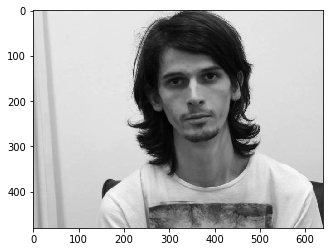

In [2]:
# Define the face and eye classifier
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haarcascade_eye.xml')
img = mpimg.imread('./data/Eye_chimeraToPublish/0/eyes003019.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')
gray = gray.reshape((480,640,1))

[[121  53  49  49]
 [ 48  66  47  47]]


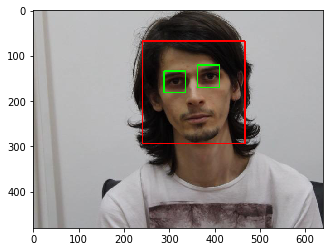

In [3]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
# plt.plot(121,53,'o')
plt.imshow(img)
# cv2.imshow('img',gray)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
print(eyes)

In [4]:
# load in data
def load_eye_cinmera():
    X = []
    y = []
    for i in range(6):
        faces_folder_path = "./data/Eye_chimeraToPublish/" + str(i)
        for f in glob.glob(os.path.join(faces_folder_path, "*.jpg")):
            img = io.imread(f)
#             print(img.shape)
            if img.shape != (480, 640, 3):
                img = cv2.resize(img,(640, 480),interpolation=cv2.INTER_CUBIC)
            X.append(img)
            y.append(i)
    return X, y
X, y = load_eye_cinmera()

In [33]:
# load in data, image/label/matrix.
def load_eye_cinmera():
    X = []
    y = []
    Mat = []
    X_left = []
    y_left = []
    X_right = []
    y_right = []
    for i in range(7):
        faces_folder_path = "./data/Eye_chimeraToPublish/" + str(i)
        for f in glob.glob(os.path.join(faces_folder_path, "*.jpg")):
            f_name = os.path.basename(f)
            f_basename = f_name.split(".", 1)[0]
            mat_name = f_basename + ".mat"
            mat_path = os.path.join(faces_folder_path, mat_name)
            
            img = io.imread(f)
            X.append(img)
            y.append(i)
            
            Mat.append(sio.loadmat(mat_path)['eyePoints'])
#         for f in glob.glob(os.path.join(faces_folder_path, "*.mat")):
#             Mat.append(sio.loadmat(f)['eyePoints'])
    return X, y, Mat
X, y, Mat = load_eye_cinmera()

In [35]:
X = np.array(X)
print(X[1].shape)
Mat = np.array(Mat)
# Mat.shape
y = np.array(y)

(480, 640, 3)


In [39]:
def extract_eye(X, Mat, pad=10):
    """given an image, return the box containing eye."""
    X_left = []
    X_right = []
    for (img, mat) in zip(X, Mat):
        # the four egdes of left and right eyes
        left_left_x = mat[0][0]
        left_right_x = mat[1][0]
        left_top_y = mat[2][1]
        left_bottom_y = mat[3][1]
        right_left_x = mat[5][0]
        right_right_x = mat[6][0]
        right_top_y = mat[7][1]
        right_bottom_y = mat[8][1]
        # cut eyes images from the original one
        left_eye = img[left_top_y-pad : left_bottom_y+pad, left_left_x-pad : left_right_x+pad, :]
        right_eye = img[right_top_y-pad : right_bottom_y+pad, right_left_x-pad : right_right_x+pad, :]
        
        # reshape eye images to 50x42
        X_left.append(cv2.resize(left_eye,(42, 50),interpolation=cv2.INTER_CUBIC))
        X_right.append(cv2.resize(right_eye,(42, 50),interpolation=cv2.INTER_CUBIC))
        
    return np.array(X_left), np.array(X_right)
X_left, X_right = extract_eye(X, Mat)


In [46]:
# Stack left and right eyes together. X_left_right is (1135, 50, 42, 6)
X_left_right = np.empty((1135, 50, 42, 6))
X_left_right[:,:,:,0:3] = X_left
X_left_right[:,:,:,3:6] = X_right
X_left_right.shape



(1135, 50, 42, 6)

In [50]:
# Split train and test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_left_right, y, test_size=0.5, random_state=42)
print("X_train size: ", len(X_train))
print("X_test size: ", len(X_test))
# chang data type to floate32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train size:  567
X_test size:  568


In [53]:
"""Build a simple regression model"""
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D, MaxPooling2D, Cropping2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

# FLAG == 0: train left; # FLAG == 1: train right
FLAG = 0
if FLAG == 0:
    X_train_single = X_train[:,:,:,0:3]
elif FLAG == 1:
    X_train_single = X_train[:,:,:,3:6]
print(X_train_single.shape)
y_train_ctg = to_categorical(np.array(y_train), num_classes=7)
# define data preparation
# datagen = ImageDataGenerator(zca_whitening=True)
datagen = ImageDataGenerator()
# fit parameters from data
datagen.fit(X_train_single)
# configure batch size and retrieve one batch of images
X_batch, y_batch = datagen.flow(X_train_single, y_train_ctg, batch_size=32)

# y_train_ctg = to_categorical(np.array(y_train), num_classes=7)
# print(y_ctg)

model = Sequential()
# input layer, normalize
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(50,42,3)))
# crop 70 rows of pixels on the top and 25 rows of pixels on the bottom.
model.add(Convolution2D(6, 7, 7, activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(16, 7, 7, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
# model.add(Dense(120))
model.add(Dense(84))
# output regression layer
model.add(Dense(7))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
res = model.fit(X_batch, y_batch, validation_split=0.1, shuffle=True, nb_epoch=2)
model.save("./models/left_init.h5")

(567, 50, 42, 3)


ValueError: too many values to unpack (expected 2)

In [124]:
res.history

{'acc': [0.27973568295067103],
 'loss': [9.4255388864861711],
 'val_acc': [0.0],
 'val_loss': [7.0294777265204251]}

2


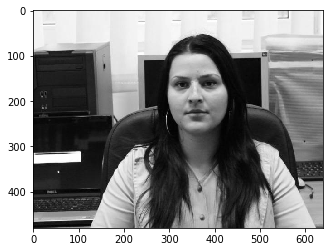

In [18]:
def detect_eyes(img):
    """Detect the left and right eyes in the image, and return two eyes image."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     plt.imshow(gray, cmap='gray')
    gray = gray.reshape((480,640,1))
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
#     print("len of """Build a simple regression model"""
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D, MaxPooling2D, Cropping2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
# crop 70 rows of pixels on the top and 25 rows of pixels on the bottom.
model.add(Cropping2D(cropping=((70, 25), (0, 0))))
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(16, 5, 5, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
# output regression layer
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2)

model.save("./models/model_aug_2e.h5")faces: ", len(faces))
    copy_img = deepcopy(img)
    eyes = []
    for (x,y,w,h) in faces:
        cv2.rectangle(copy_img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = copy_img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    if eyes is None:
        return None
    # show the facial image
#     plt.imshow(roi_color)
    return eyes
eyes_d = detect_eyes(X[7])
print(len(eyes_d))

314


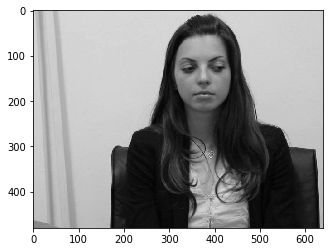

In [19]:
"""314 images have more or less than 2 eyes with viola-jones eye detector."""
count = 0
for img in X:
    eyes_d = detect_eyes(img)
    if len(eyes_d) != 2:
        count += 1
print(count)